In [1]:
import sys
import pip
import re, numpy as np, pandas as pd
from pprint import pprint
import json
import collections
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import ssl
import timeit
start = timeit.default_timer()

In [2]:
stop_words = stopwords.words('english')
stop_words.extend(['amp','https','http','co','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [3]:
def read_data():
    #return pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
    return pd.read_json(open("nonGeoLondonJan","r",encoding="utf"),lines=True)

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN','PROPN']):
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []

    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out





In [4]:
df = read_data()
data = df.text.values.tolist()
data_words = list(sent_to_words(data))

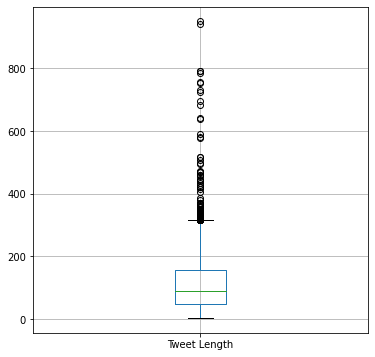

In [5]:
df["Tweet Length"]= df["text"].str.len()
bp = df.boxplot(column="Tweet Length", figsize=(6,6))

In [6]:
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=8) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=8)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
data_ready = process_words(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [8]:

# Build LDA model
coherence = []
for n in range(5,25):
    print("Topic ",n)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=n, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=20,
                                               alpha='auto',
                                               #iterations=200,
                                               per_word_topics=True)
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model,
                                                    texts=data_ready,
                                                    dictionary=id2word,
                                                    coherence='c_v')
    coherence.append((n,cm.get_coherence()))
    print(coherence)





Topic  5
[(5, 0.43682004196103036)]
Topic  6
[(5, 0.43682004196103036), (6, 0.4701216477595686)]
Topic  7
[(5, 0.43682004196103036), (6, 0.4701216477595686), (7, 0.48610307089415505)]
Topic  8
[(5, 0.43682004196103036), (6, 0.4701216477595686), (7, 0.48610307089415505), (8, 0.5294352214788042)]
Topic  9
[(5, 0.43682004196103036), (6, 0.4701216477595686), (7, 0.48610307089415505), (8, 0.5294352214788042), (9, 0.5176412033945964)]
Topic  10
[(5, 0.43682004196103036), (6, 0.4701216477595686), (7, 0.48610307089415505), (8, 0.5294352214788042), (9, 0.5176412033945964), (10, 0.5538543867179461)]
Topic  11
[(5, 0.43682004196103036), (6, 0.4701216477595686), (7, 0.48610307089415505), (8, 0.5294352214788042), (9, 0.5176412033945964), (10, 0.5538543867179461), (11, 0.549412975482924)]
Topic  12


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (20,) and (7,)

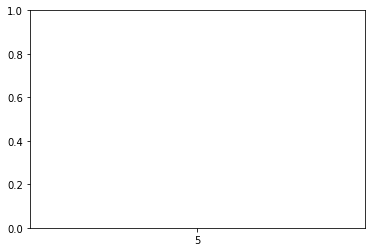

In [9]:
x, y = zip(*coherence)
x = [str(i) for i in range(5,25)]
    
plt.plot(x,y,'xb-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [10]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=20,
                                           alpha='auto',
                                           #iterations=200,
                                           per_word_topics=True)



In [11]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.2856,"people, time, love, thing, year, woman, player...","[giggs, game]"
1,1,6.0,0.3197,"mason_greenwood, rule, law, crime, champion, h...","[tokenomic, talk, mechanism, monopoly, relatio..."
2,2,7.0,0.6091,"today, way, london, work, money, team, country...","[point, admit, expectation, skill, experience,..."
3,3,8.0,0.2304,"day, game, world, life, week, sunday, job, per...","[twitter, storm]"
4,4,0.0,0.2590,"wordle, man, greenwood, mate, home, tweet, wor...",[wordle]
...,...,...,...,...,...
14995,14995,8.0,0.2035,"day, game, world, life, week, sunday, job, per...","[man, hat, trick, kna, dkm, lth, avebea]"
14996,14996,0.0,0.3585,"wordle, man, greenwood, mate, home, tweet, wor...","[wordle, yesterday]"
14997,14997,9.0,0.3321,"people, time, love, thing, year, woman, player...","[woman, west, london, app, part, km, saturday,..."
14998,14998,9.0,0.5973,"people, time, love, thing, year, woman, player...","[woman, economist, woman, economist, buddy, ev..."


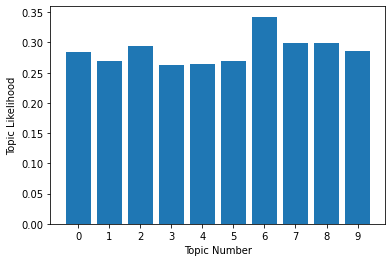

0.28708702


In [15]:
x=['0','1','2','3','4','5','6','7','8','9']
y=[]
for i in range(10):
    y.append(df_dominant_topic[df_dominant_topic['Dominant_Topic']==i]['Topic_Perc_Contrib'].mean())
plt.bar(x,y)
plt.xlabel("Topic Number")
plt.ylabel("Topic Likelihood")
plt.show()
print(np.mean(y))

In [21]:
for i, row in df_dominant_topic[df_dominant_topic['Dominant_Topic']==6].iterrows():
    print(row['Text'])

['tokenomic', 'talk', 'mechanism', 'monopoly', 'relationship', 'consumer', 'provider', 'side', 'middleman', 'friction']
['cider']
['champion', 'human_right', 'violation', 'dictator', 'rule', 'law', 'atrocity', 'crime', 'humanity', 'commits_endm', 'dictatorship', 'jzyzgughx']
['kookaburra', 'jay', 'fd', 'lzmrww']
['morning', 'matteo', 'picture']
['timaya', 'nigerian', 'friend', 'boy', 'girl', 'pqyuviphgt', 'nigeria', 'nigerianew', 'dpdfm']
['scan', 'painkiller', 'scan', 'march']
['working', 'morning', 'tea', 'wake']
['fxn']
['champion', 'human_right', 'violation', 'dictator', 'rule', 'law', 'atrocity', 'crime', 'humanity', 'commits_endm', 'dictatorship', 'sijh']
['champion', 'human_right', 'violation', 'dictator', 'rule', 'law', 'atrocity', 'crime', 'humanity', 'commits_endm', 'dictatorship', 'nfxkney']
['sec', 'liz_truss', 'vladimir', 'putin', 'invasion', 'result', 'quagmire', 'soviet', 'afghanistan', 'chechnya']
['mp', 'energy_price', 'recoup', 'energy', 'water', 'company', 'sharehold

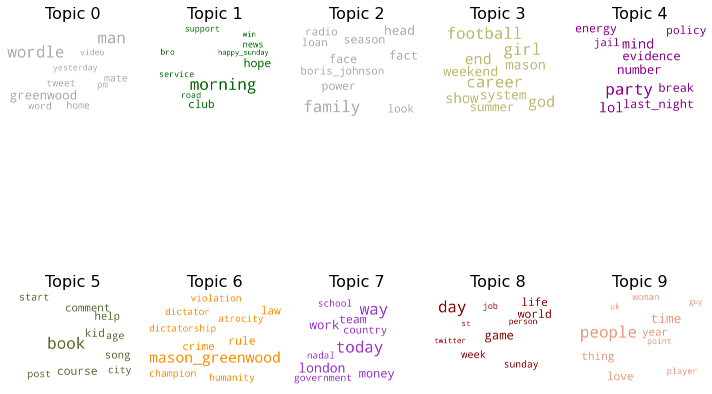

In [14]:
# 1. Wordcloud of Top N words in each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in list(mcolors.CSS4_COLORS.items())[24:38]]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=14, formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i>13:
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [16]:
cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model,
                                                texts=data_ready,
                                                dictionary=id2word,
                                                coherence='c_v')

[0.553920131512988,
 0.6231698983311657,
 0.7049399280661913,
 0.6383644489152184,
 0.7168111198242575,
 0.6611250091019768,
 0.43368406847473684,
 0.3819310899490917,
 0.4400111103572237,
 0.339730581115735]

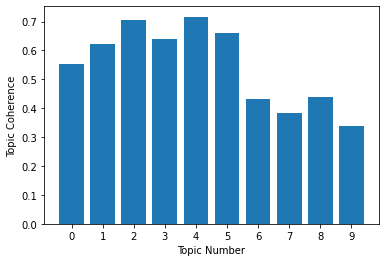

In [19]:
x=['0','1','2','3','4','5','6','7','8','9']
y=cm.get_coherence_per_topic()
plt.bar(x,y)
plt.xlabel("Topic Number")
plt.ylabel("Topic Coherence")
plt.show()